# Example 1: Optimization of a State-to-State Transfer in a Two-Level-System

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

This first example illustrates the basic use of the `Krotov.jl` by solving a
simple canonical optimization problem: the transfer of population in a two
level system.

In [1]:
using DrWatson
@quickactivate "KrotovTests"

In [2]:
using QuantumControl
using LinearAlgebra

In [3]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)

## Two-level Hamiltonian

We consider the Hamiltonian $\op{H}_{0} = - \frac{\omega}{2} \op{\sigma}_{z}$, representing
a simple qubit with energy level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control field $\epsilon(t)$ is assumed to couple via
the Hamiltonian $\op{H}_{1}(t) = \epsilon(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control field effectively drives transitions between both qubit
states.

We we will use

In [4]:
ϵ(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=5, t_rise=0.3, func=:blackman);

In [5]:
"""Two-level-system Hamiltonian."""
function hamiltonian(Ω=1.0, ϵ=ϵ)
    σ̂_z = ComplexF64[
        1  0
        0 -1
    ]
    σ̂_x = ComplexF64[
        0  1
        1  0
    ]
    Ĥ₀ = -0.5 * Ω * σ̂_z
    Ĥ₁ = σ̂_x
    return (Ĥ₀, (Ĥ₁, ϵ))
end;

In [6]:
H = hamiltonian();

The control field here switches on from zero at $t=0$ to it's maximum amplitude
0.2 within the time period 0.3 (the switch-on shape is half a [Blackman pulse](https://en.wikipedia.org/wiki/Window_function#Blackman_window)).
It switches off again in the time period 0.3 before the
final time $T=5$). We use a time grid with 500 time steps between 0 and $T$:

In [7]:
tlist = collect(range(0, 5, length=500));

In [8]:
function plot_control(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="amplitude", legend=false)
end

plot_control(ϵ::T, tlist) where {T<:Function} = plot_control([ϵ(t) for t in tlist], tlist);

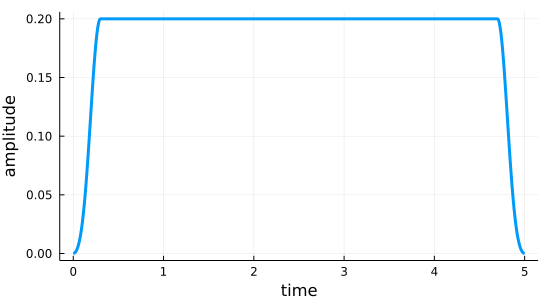

In [9]:
fig = plot_control(H[2][2], tlist)

## Optimization target

The `krotov` package requires the goal of the optimization to be described by a
list of `Objective` instances. In this example, there is only a single
objective: the state-to-state transfer from initial state $\ket{\Psi_{\init}} =
\ket{0}$ to the target state $\ket{\Psi_{\tgt}} = \ket{1}$, under the dynamics
of the Hamiltonian $\op{H}(t)$:

In [10]:
function ket(label)
    result = Dict("0" => Vector{ComplexF64}([1, 0]), "1" => Vector{ComplexF64}([0, 1]),)
    return result[string(label)]
end;

In [11]:
objectives = [Objective(initial_state=ket(0), generator=H, target_state=ket(1))]

1-element Vector{QuantumControlBase.Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(Main.##295.ϵ)}}}}:
 QuantumControlBase.Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(Main.##295.ϵ)}}}(ComplexF64[1.0 + 0.0im, 0.0 + 0.0im], (ComplexF64[-0.5 - 0.0im -0.0 - 0.0im; -0.0 - 0.0im 0.5 - 0.0im], (ComplexF64[0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im], Main.##295.ϵ)), ComplexF64[0.0 + 0.0im, 1.0 + 0.0im])

In [12]:
problem = ControlProblem(
    objectives=objectives,
    pulse_options=IdDict(
        ϵ => Dict(
            :lambda_a => 5,
            :update_shape =>
                t -> QuantumControl.Shapes.flattop(t, T=5, t_rise=0.3, func=:blackman),
        )
    ),
    tlist=tlist,
    iter_stop=50,
    chi=QuantumControl.Functionals.chi_ss!,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

## Simulate dynamics under the guess field

Before running the optimization procedure, we first simulate the dynamics under the
guess field $\epsilon_{0}(t)$. The following solves equation of motion for the
defined objective, which contains the initial state $\ket{\Psi_{\init}}$ and
the Hamiltonian $\op{H}(t)$ defining its evolution.

In [13]:
guess_dynamics = propagate_objective(
    objectives[1],
    problem.tlist;
    storage=true,
    observables=(Ψ -> abs.(Ψ) .^ 2,)
)

2×500 Matrix{Float64}:
 1.0  1.0          1.0          1.0          …  0.951457   0.951459  0.951459
 0.0  7.73456e-40  2.03206e-11  2.96638e-10     0.0485427  0.048541  0.048541

In [14]:
function plot_population(pop0::Vector, pop1::Vector, tlist)
    fig = plot(tlist, pop0, label="0", xlabel="time", ylabel="population")
    plot!(fig, tlist, pop1; label="1")
end;

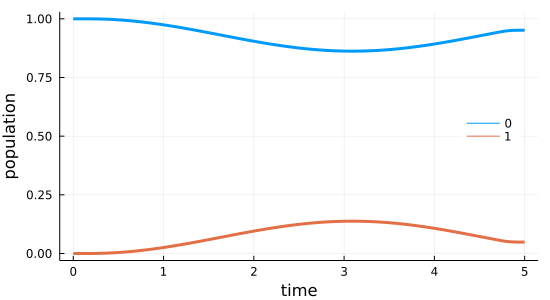

In [15]:
fig = plot_population(guess_dynamics[1, :], guess_dynamics[2, :], tlist)

## Optimize

In the following we optimize the guess field $\epsilon_{0}(t)$ such
that the intended state-to-state transfer $\ket{\Psi_{\init}} \rightarrow
\ket{\Psi_{\tgt}}$ is solved, via `optimize` routine.
It requires, besides the previously defined
`objectives`, information about the optimization functional $J_T$ (implicitly,
via `chi_constructor`, which calculates the states $\ket{\chi} =
\frac{J_T}{\bra{\Psi}}$).

In [16]:
opt_result, file = @optimize_or_load(
    datadir(),
    problem,
    method = :krotov,
    prefix = "TLSOCT",
    savename_kwargs = Dict(:ignores => ["chi"], :connector => "#")
);

[ Info: File /home/runner/work/Krotov.jl/Krotov.jl/docs/data/TLSOCT#J_T=J_T_ss#iter_stop=50#method=krotov.jld2 does not exist. Producing it now...
 iter.        J_T   ∫gₐ(t)dt          J       ΔJ_T         ΔJ    secs
     0   9.51e-01   0.00e+00   9.51e-01        n/a        n/a     1.3
     1   9.24e-01   1.20e-02   9.36e-01  -2.71e-02  -1.50e-02     0.8
     2   8.83e-01   1.83e-02   9.02e-01  -4.11e-02  -2.28e-02     0.0
     3   8.23e-01   2.71e-02   8.50e-01  -6.06e-02  -3.35e-02     0.0
     4   7.37e-01   3.84e-02   7.76e-01  -8.52e-02  -4.68e-02     0.0
     5   6.26e-01   5.07e-02   6.77e-01  -1.11e-01  -6.05e-02     0.0
     6   4.96e-01   6.04e-02   5.56e-01  -1.31e-01  -7.02e-02     0.0
     7   3.62e-01   6.30e-02   4.25e-01  -1.34e-01  -7.09e-02     0.0
     8   2.44e-01   5.65e-02   3.00e-01  -1.18e-01  -6.15e-02     0.0
     9   1.53e-01   4.39e-02   1.97e-01  -9.03e-02  -4.64e-02     0.0
    10   9.20e-02   3.02e-02   1.22e-01  -6.14e-02  -3.12e-02     0.0
    11   5.35

In [17]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2022-02-15T18:32:52.136
- Number of objectives: 1
- Number of iterations: 18
- Value of functional: 9.91129e-04
- Reason for termination: J_T < 10⁻³
- Ended at 2022-02-15T18:32:54.288 (2 seconds, 152 milliseconds)


We can plot the optimized field:

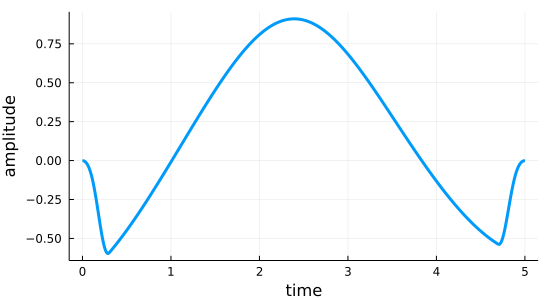

In [18]:
fig = plot_control(opt_result.optimized_controls[1], tlist)

## Simulate the dynamics under the optimized field

Having obtained the optimized control field, we can simulate the dynamics to
verify that the optimized field indeed drives the initial state
$\ket{\Psi_{\init}} = \ket{0}$ to the desired target state
$\ket{\Psi_{\tgt}} = \ket{1}$.

In [19]:
opt_dynamics = propagate_objective(
    objectives[1],
    problem.tlist;
    controls_map=IdDict(ϵ => opt_result.optimized_controls[1]),
    storage=true,
    observables=(Ψ -> abs.(Ψ) .^ 2,)
)

2×500 Matrix{Float64}:
 1.0  1.0          1.0          1.0         …  0.000991129  0.000991129
 0.0  1.05393e-38  2.74451e-10  3.97943e-9     0.999009     0.999009

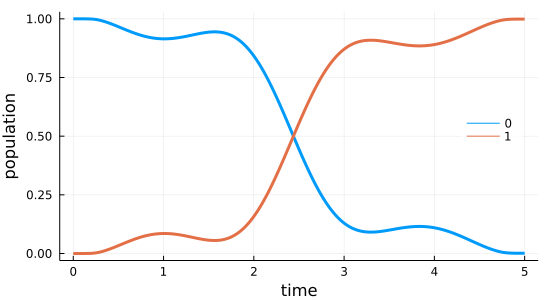

In [20]:
fig = plot_population(opt_dynamics[1, :], opt_dynamics[2, :], tlist)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*